In [1]:
import nltk
import re
import numpy as np
import pandas as pd
from pprint import pprint
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import spacy
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['http','https'])

In [3]:
# Import Dataset
df = pd.read_csv('master_policy1.csv')
df.head()

,platform,post_id,username,text
0,instagram,B--cvRQHJRp,photographyholic,singapore now it is mandatory with immediate e...
1,instagram,B-9dOShHqC-,mothershipsg,just in first time offenders will face a s 300...
2,instagram,B_Aeqc0nnVm,mothershipsg,first time offenders will face a fine of below...
3,instagram,B-_uYTVAjLI,sgagsg,hello police please fine this sound by @mingwe...
4,instagram,B_HnKCNHUxp,sgmemetextbook,the 600 the government gave out on 14 4 2x 300...


In [4]:
# Convert to list
data = df.text.values.tolist()

# Remove URL
data = [ re.sub(r"(?i)\b((?:[a-z][\w-]+:(?:/{1,3}|[a-z0-9%])|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'\.,<>?«»“”‘’]))", '', s, flags=re.M) for s in data ]

# Remove new line characters
data = [re.sub(r'\s+', ' ', s) for s in data]

In [5]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

In [6]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['singapore', 'now', 'it', 'is', 'mandatory', 'with', 'immediate', 'effect', 'for', 'everyone', 'to', 'wear_mask', 'when', 'they', 'step', 'out', 'of', 'your', 'house', 'as', 'part', 'of', 'stricter', 'measures', 'to', 'curb', 'the', 'further', 'spread', 'of', 'the', 'coronavirus', 'those', 'who', 'do', 'not', 'risk', 'fine', 'for', 'first', 'time', 'offenders', 'there', 'are', 'exemptions', 'for', 'those', 'engaging', 'in', 'strenuous', 'exercise', 'and', 'children', 'below', 'the', 'age', 'of', 'two', 'as', 'medical', 'experts', 'recommend', 'against', 'them', 'wearing', 'masks', 'national', 'development', 'minister', 'lawrence', 'wong', 'said', 'at', 'media', 'conference', 'on', 'tuesday', 'april', 'please', 'stay_home', 'sgunited', 'covi', 'sgunited', 'singapore', 'singapore', 'streetshared', 'instagram', 'artofvisuals', 'exploresg', 'instasg', 'whatissingapore', 'iluvsg', 'citygrammers', 'kilogrammerz', 'streetshated', 'thankyou', 'singapore', 'singapore']


In [7]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [8]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['mandatory', 'immediate', 'effect', 'step', 'house', 'part', 'strict', 'measure', 'curb', 'spread', 'risk', 'fine', 'first', 'time', 'offender', 'exemption', 'engage', 'strenuous', 'exercise', 'child', 'age', 'medical', 'expert', 'recommend', 'wear', 'mask', 'say', 'please', 'stay_home', 'sgunited', 'covi', 'sgunite', 'streetshare', 'artofvisual', 'whatissingapore', 'citygrammer', 'streetshate']]


In [9]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 1)]]


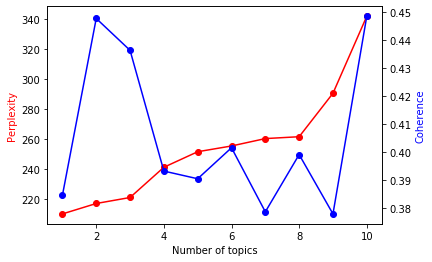

In [10]:
perplexity_list = []
coherence_list = []
num_topics = range(1,11)

for i in num_topics:
    # Build LDA model
    lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=i, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)
    
    log_perplexity = lda_model.log_perplexity(corpus)
    perplexity = 2**(-log_perplexity)
    perplexity_list.append(perplexity)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    coherence_list.append(coherence_lda)
    
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(num_topics,perplexity_list, marker='o', color =  'r')
ax2.plot(num_topics, coherence_list, marker = 'o', color = 'b')

ax1.set_xlabel('Number of topics')
ax1.set_ylabel('Perplexity', color = 'r')
ax2.set_ylabel('Coherence', color = 'b')

plt.show()

In [11]:
final_num_topic = 2

# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=final_num_topic, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [12]:
# Print topic list

for num, topic in lda_model.show_topics(formatted=True, num_topics=final_num_topic, num_words=10):
    print ("Topic {}: ".format(num))
    for t in topic.split('+ '):
        print (t)
    print ('-' * 20)


# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

Topic 0: 
0.010*"park" 
0.010*"close" 
0.009*"closure" 
0.007*"drink" 
0.007*"bubble_tea" 
0.006*"food" 
0.006*"sugar" 
0.006*"outlet" 
0.006*"queue" 
0.005*"staff"
--------------------
Topic 1: 
0.010*"chinese" 
0.009*"people" 
0.009*"go" 
0.008*"think" 
0.007*"would" 
0.007*"say" 
0.007*"time" 
0.006*"even" 
0.006*"good" 
0.006*"make"
--------------------

Perplexity:  -7.761870729352744

Coherence Score:  0.4477248711538904


In [13]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x    y  topics  cluster       Freq
topic                                           
1      0.148473  0.0       1        1  82.564484
0     -0.148473  0.0       2        1  17.435513, topic_info=         Term       Freq      Total Category  logprob  loglift
335      park  42.000000  42.000000  Default  30.0000  30.0000
141     close  46.000000  46.000000  Default  29.0000  29.0000
142   closure  35.000000  35.000000  Default  28.0000  28.0000
497      food  56.000000  56.000000  Default  27.0000  27.0000
935     drink  32.000000  32.000000  Default  26.0000  26.0000
..        ...        ...        ...      ...      ...      ...
231     queue  23.534647  46.566944   Topic2  -5.1734   1.0642
147      open  12.010727  15.405422   Topic2  -5.8461   1.4977
180  delivery  17.093645  32.512680   Topic2  -5.4932   1.1037
144      last  16.521812  41.087399   Topic2  -5.5272   0.8356
337     covid  13.377983  35.394279   Topic2  -5.7383   0.7737

[118 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
2879      2  0.961303  addictive
4576      2  0.971583   advisory
319       1  0.217328      allow
319       2  0.782382      allow
174       1  0.963983       also
...     ...       ...        ...
200       1  0.974499       well
200       2  0.024987       well
643       1  1.000756       work
135       1  0.997235      would
135       2  0.006830      would

[131 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1])